In [0]:
from fastai.text import *
import numpy as np
import pandas as pd

In [2]:
import fastai; fastai.__version__

'1.0.59'

In [0]:
url = 'https://raw.githubusercontent.com/ShadmanShoumikmq/ADS-Proj/master/reviews.csv'

In [4]:
dff = pd.read_csv(url)
df = dff.loc[0:50000,]
df.tail()

,Id,Review,Label
49996,49996,Good for beginner! Thanks University of Toront...,5
49997,49997,This course is well designed. So every one wit...,5
49998,49998,I have absolutely no background whatsoever in ...,5
49999,49999,It was a really helpful course! I had previous...,4
50000,50000,Excellent initiation in programming with python,5


In [5]:
!pip install vaderSentiment 

     |████████████████████████████████| 133kB 25.6MB/s 


In [0]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [7]:
df['ReviewScore'] = df['Review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
positive_num = len(df[df['ReviewScore'] >=0.05])
neutral_num = len(df[(df['ReviewScore'] >-0.05) & (df['ReviewScore']<0.05)])
negative_num = len(df[df['ReviewScore']<=-0.05])

In [9]:
df['vaderSentiment']= df['ReviewScore'].map(lambda x:int(2) if x>=0.05 else int(1) if x<=-0.05 else int(0) )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df.loc[df['ReviewScore'] >=0.05,"vaderSentimentLabel"] ="positive"
df.loc[(df['ReviewScore'] >-0.05) & (df['ReviewScore']<0.05),"vaderSentimentLabel"]= "neutral"
df.loc[df['ReviewScore']<=-0.05,"vaderSentimentLabel"] = "negative"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
df.head()

,Id,Review,Label,ReviewScore,vaderSentiment,vaderSentimentLabel
0,0,good and interesting,5,0.6808,2,positive
1,1,"This class is very helpful to me. Currently, I...",5,0.4754,2,positive
2,2,like!Prof and TAs are helpful and the discussi...,5,0.8843,2,positive
3,3,Easy to follow and includes a lot basic and im...,5,0.5719,2,positive
4,4,Really nice teacher!I could got the point eazl...,4,0.3266,2,positive


In [0]:
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [13]:
df.head()

,vaderSentimentLabel,Id,Review,Label,ReviewScore,vaderSentiment
0,positive,0,good and interesting,5,0.6808,2
1,positive,1,"This class is very helpful to me. Currently, I...",5,0.4754,2
2,positive,2,like!Prof and TAs are helpful and the discussi...,5,0.8843,2
3,positive,3,Easy to follow and includes a lot basic and im...,5,0.5719,2
4,positive,4,Really nice teacher!I could got the point eazl...,4,0.3266,2


In [0]:
train_texts = df.loc[0:26000, 'Review'].values
train_labels = df.loc[0:26000, 'vaderSentimentLabel'].values
valid_texts = df.loc[26001:50000, 'Review'].values
valid_labels = df.loc[26001:50000, 'vaderSentimentLabel'].values

np.random.seed(42)
train_idx = np.random.permutation(len(train_texts))
valid_idx = np.random.permutation(len(valid_texts))

train_texts = train_texts[train_idx]
valid_texts = valid_texts[valid_idx]
train_labels = train_labels[train_idx]
valid_labels = valid_labels[valid_idx]
col_names = ['vaderSentimentLabel','Review']
df_train = pd.DataFrame({'Review':train_texts, 'vaderSentimentLabel':train_labels}, columns=col_names)
df_valid = pd.DataFrame({'Review':valid_texts, 'vaderSentimentLabel':valid_labels}, columns=col_names)

In [0]:
data_lm = TextDataBunch.from_df('./', train_df= df_train ,valid_df = df_valid)

In [0]:
data_lm.save()

In [17]:
data = TextClasDataBunch.from_df('./', train_df= df_train ,valid_df = df_valid)
data.show_batch()

text,target
"xxbos xxmaj this is my feedback as a xxmaj beta - xxmaj tester for the course : xxmaj week xxup xxunk thought that the videos were clear , well organized and flowed well from topic to topic . xxmaj there was a clear logic as the professor developed the various ratios . xxmaj what was missing for me was some in - line quizzes . xxmaj not the “ tell",positive
"xxbos i will review this course xxunk its pros and cons . xxmaj pros:- xxmaj the instructor : he is a captivating person . xxmaj it really seems that he like game development , he make jokes and try to make the course interesting . xxmaj so , he ’s personality is makes the course less boring . xxmaj xxunk xxmaj the course name : when i saw “ design",positive
"xxbos xxmaj this course , which sounds promising in title and syllabus , has many glaring deficiencies . xxmaj in fact , i feel terrible if anyone xxunk up $ 100 + for it . xxmaj it roughly covers some concepts of data science , but never at scale , and never very clearly . xxmaj my background is a science ph.d. with a lot of computational science experience .",positive
"xxbos xxmaj hi , i am an xxup it specialist ( 30 years experience ) . i xxunk the course so i could learn about xxup ibm xxmaj bluemix and iot development , and extend my skills / understanding of the environment . xxmaj however , i have very little good to say about this course offering . i had numerous issues with what was offered : xxmaj the videos",positive
"xxbos xxmaj this course is xxunk had come upto week 4 . xxmaj while xxmaj chris xxmaj impey is knowledgeable and good , the course structure is very poor and leaves a lot to be desired . i would venture to make some suggestions : a . xxmaj xxunk each video to a max of 7 minutes . xxmaj more than that makes one xxunk . xxmaj reduce the number",positive


In [18]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [19]:
data.train_ds[0][0]

Text xxbos very useful !

In [20]:
data.train_ds[0][0].data[:5]

array([ 2, 22, 62, 24])

In [0]:
data = (TextList.from_df(df,".", cols='Review')
                .split_by_rand_pct(0)
                .label_from_df(cols= 0)
                .databunch()) 

In [0]:
bs=48

In [0]:
data_lm = (TextList.from_df(df,".",cols='Review')
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(".", 'data_lm.pkl', bs=bs)

In [25]:
data_lm.show_batch()

idx,text
0,"especially xxup it and xxmaj business xxmaj managers ! xxbos xxmaj one of the most useful course on xxup it xxmaj management ! xxbos i was disappointed because the name is misleading . xxmaj the course provides a good introduction & overview of the responsibilities of the xxup xxunk , but has very little specifically digital content . xxmaj it deals with two - speed xxup it in a single"
1,"assignments r too xxunk you can make them a bit easy , the last one , ie with graphs and trees was a xxunk . xxmaj if the maths required is so high , please take a week to first explain the math fresher required in course and then start the main course xxbos xxmaj this is great course xxbos xxmaj it 's an amazing courses aiming to high -"
2,"not like to pull its rating back , so i leave xxunk you ! xxbos xxmaj if you can finish this course you will be more then efficient in xxup sql . xxbos xxmaj very complete and up to the point ! xxmaj lots of useful resources ! xxbos xxmaj unprecedented high speaking speed . xxbos xxmaj this was one of the best courses i 've ever taken . xxmaj"
3,"teacher for all the hard work . xxbos it was fun ... xxbos xxmaj very easy to understand . e xxbos xxmaj great xxmaj course xxbos xxmaj thanks to xxmaj mr. xxmaj jogesh for carrying out complex concepts with ease . xxbos xxmaj awesome course xxbos very helpful for newbies xxbos xxmaj this course -- actually , both the 2nd and 3rd courses in this specialization -- are like """
4,"is not a basic excel training . xxmaj the title is appropriately set as "" xxmaj mastering "" xxmaj data xxmaj analysis in xxmaj excel ... xxbos i did learn a few helpful tips for analyzing data with excel - particularly how to do a regression analysis in excel which is something i did n't know and is not intuitive . xxmaj but for a course that is supposed to"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


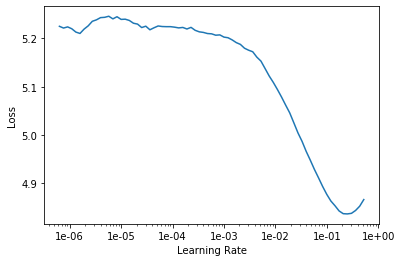

In [28]:
learn.recorder.plot(skip_end=15)

In [29]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.640992,3.524605,0.306889,01:09


In [0]:
learn.save('fit_head')

In [0]:
TEXT = "very informative and i learned a lot"
N_WORDS = 40
N_SENTENCES = 2

In [32]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

very informative and i learned a lot . The course was well structured and concise . a great intro to the subject was a very useful course . xxbos Excellent course . It is very good for beginners . xxbos i recommend this course
very informative and i learned a lot of things about Tableau ! xxbos Really loved a pleasure . Thanks a lot . The best thing i 've done to my life is that i learned a lot . i enjoy it .


In [0]:
learn.unfreeze()

In [34]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.395588,3.411004,0.321987,01:28
1,3.302568,3.346292,0.330332,01:28
2,3.126111,3.320657,0.333358,01:28
3,2.920224,3.334214,0.333253,01:28
4,2.764035,3.359477,0.331665,01:28


In [0]:
learn.save('fine_tuned')

In [0]:
TEXT = "very informative and i learned a lot"
N_WORDS = 40
N_SENTENCES = 2

In [37]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

very informative and i learned a lot of new things xxbos i think the course is a really good introduction to the technology , technology and its applications . It is too short and does not focus on the background . As i have a
very informative and i learned a lot . xxbos It 's a great course . It 's really helpful to improve my grammar and grammar . Thank you very much for this course ! xxbos Enjoyed it a lot . Very practical


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
data_clas = (TextList.from_df(df,".",cols= 'Review', vocab=data_lm.vocab)
             .split_by_rand_pct(0.3)
             .label_from_df(cols='vaderSentimentLabel')
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(".", 'data_clas.pkl', bs=bs)

In [41]:
data_clas.show_batch()

text,target
"xxbos xxmaj this is my feedback as a xxmaj beta - xxmaj tester for the course : xxmaj week xxup xxunk thought that the videos were clear , well organized and flowed well from topic to topic . xxmaj there was a clear logic as the professor developed the various ratios . xxmaj what was missing for me was some in - line quizzes . xxmaj not the “ tell",positive
"xxbos xxmaj now that i have completed the course i 'd like to give some feedback on how i think it xxunk . xxmaj quizzes are horrible . xxmaj the fact we get no feedback on incorrect answers is not very helpful . xxmaj there are only 3 quizzes where i missed just one question but no matter what , i ca n't get them correct . xxmaj it would",positive
"xxbos xxmaj excellent course , period . xxmaj this is the first course i 've taken from xxmaj coursera . xxmaj before the course i knew something about xxup html , xxup css and xxmaj javascript but not too much . xxmaj first week is a piece of cake . xxmaj second week was also easy but i did not have a strong logic about the "" box model """,positive
"xxbos xxmaj about : xxmaj first xxmaj lessons contain some xxmaj interface / xxmaj xxunk errors . xxmaj hi , i reckon it 's a tad too early to rate this course since it is only going to start - but i did n't see another option to contact the xxmaj course xxmaj administrator other than trough the rating process . xxmaj when going through the introduction of this course",positive
xxbos xxmaj why is this course xxunk took this course because first i liked the idea to have a history lesson spanning the age of the whole universe . xxmaj maybe it is also intriguing to explain everything just with one principle : the second law of xxunk . xxup but as it turned out they do n't have any clue what this second law of xxunk means . xxmaj,negative


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [43]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (35001 items)
x: TextList
xxbos good and interesting,xxbos xxmaj easy to follow and includes a lot basic and important techniques to use xxunk .,xxbos xxmaj really nice xxunk could got the point xxunk but the v,xxbos i was disappointed because the name is misleading . xxmaj the course provides a good introduction & overview of the responsibilities of the xxup xxunk , but has very little specifically digital content . xxmaj it deals with two - speed xxup it in a single short lecture , so of course the treatment is superficial . xxmaj it is easy to find more in - depth material freely available , on the xxunk website for example .,xxbos xxmaj one of the excellent courses at xxmaj coursera for information technology xxunk and managers .
y: CategoryList
positive,positive,positive,positive,positive
Path: .;

Valid: LabelList (15000 items)
x: TextList
xxbos i 've learnt a lot about focus and how to learn properly . xxmaj it 's a excellent 

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


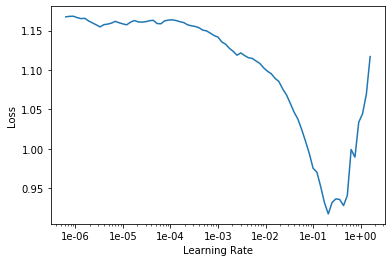

In [45]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.352839,0.308983,0.891133,00:48
1,0.317401,0.278870,0.898133,00:45
2,0.340233,0.289878,0.896933,00:46


In [47]:
learn.predict("great course")

(Category positive, tensor(2), tensor([8.6948e-04, 5.3022e-04, 9.9860e-01]))

In [48]:
learn.predict("introductions to reasoning about algorithms in a mathematical way")

(Category positive, tensor(2), tensor([0.0271, 0.1860, 0.7870]))

In [49]:
learn.predict("i doubt you 'd be anywhere near proficient after being hand")

(Category negative, tensor(0), tensor([0.8651, 0.0151, 0.1198]))